# ***Data Processing***

V. 1.14

In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import re
import pylab as pl
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
#from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')

Basic conversion to types after loading in the data from the csv. Only notable thing is that we are removing any budget data from movies that are made outside the US as their data isnt in dollars.

In [2]:
movies = pd.DataFrame(pd.read_csv("movies.csv"))
movies = movies.drop(['Unnamed: 0'], axis=1)

movies.loc[movies["Year"] == '    ', ['Year']] = 0 
movies["Year"] = movies["Year"].fillna(-1)
movies["Year"] = movies["Year"].astype(float)

movies = movies[~movies['Budget'].astype(str).str.contains('Budget:')]
movies = movies[~movies['Budget'].astype(str).str.contains('Trivia')]
movies["Budget"] = movies["Budget"].str.replace(',','')
movies["Budget"] = movies["Budget"].fillna(-1)
movies["Budget"] = movies["Budget"].astype(float)

movies["Gross US"] = movies["Gross US"].str.replace(',','')
movies["Gross US"] = movies["Gross US"].fillna(-1)
movies["Gross US"] = movies["Gross US"].astype(float)

movies["Gross WW"] = movies["Gross WW"].str.replace(',','')
movies["Gross WW"] = movies["Gross WW"].fillna(-1)
movies["Gross WW"] = movies["Gross WW"].astype(float)

movies["Language"] = movies["Language"].fillna(-1)

movies["Rating"] = movies["Rating"].fillna('Unrated')

movies["Duration"] = movies["Duration"].fillna(-1)
movies=movies.rename(columns = {'Duration':'Duration_Minutes'})

movies=movies.rename(columns = {'Average Rating':'Average_Rating'})
print(movies.dtypes)

Name                   object
Year                  float64
Genres                 object
Rating                 object
Duration_Minutes      float64
Actors                 object
Director               object
Average_Rating        float64
Budget                float64
Opening Weekend       float64
Gross US              float64
Gross WW              float64
Language               object
Production Company     object
dtype: object


In [3]:
#Cleaning Rating
drop_tv = ['TV-14' ,'TV-G', 'TV-MA', 'TV-Y', 'TV-PG' , 'TV-Y7' , 'GP' , 'Passed' , 'X' ]  #Removing TV shows/X rated movies
movies=movies[~movies['Rating'].isin(drop_tv)]
movies['Rating'] = movies['Rating'].replace({'Not Rated':'Unrated'})
movies["Rating"].value_counts()

R          3974
PG-13      2020
PG         1570
Unrated    1360
G           252
NC-17        20
Name: Rating, dtype: int64

In [4]:
#Cleaning Year
to_drop = [2020,2021,2024] #Removing future releases (no data available)
movies=movies[~movies['Year'].isin(to_drop)] 

In [5]:
#Calculating Profit/Loss for each movie
movies["Profit"] = movies["Gross US"]+movies["Gross WW"]- movies["Budget"]
movies["Status"]= np.where(movies['Profit']>1, True, False)
movies["Status"].value_counts()

True     4942
False    4242
Name: Status, dtype: int64

Cleaning up some of the columns

In [6]:
movies["Genres"] = movies["Genres"].str.replace('[','')
movies["Genres"] = movies["Genres"].str.replace(']','')
movies["Genres"] = movies["Genres"].str.replace("'",'')
movies["Actors"] = movies["Actors"].str.replace('[','')
movies["Actors"] = movies["Actors"].str.replace(']','')
movies["Actors"] = movies["Actors"].str.replace("'",'')
movies["Director"] = movies["Director"].str.replace('[','')
movies["Director"] = movies["Director"].str.replace(']','')
movies["Director"] = movies["Director"].str.replace("'",'')
movies["Production Company"] = movies["Production Company"].str.replace('[','')
movies["Production Company"] = movies["Production Company"].str.replace(']','')
movies["Production Company"] = movies["Production Company"].str.replace("'",'')
movies["Language"] = movies["Language"].str.replace('[','')
movies["Language"] = movies["Language"].str.replace(']','')
movies["Language"] = movies["Language"].str.replace("'",'')
# movies.head()

In [7]:
indexNames = movies[ (movies['Year'] == 0) & (movies['Rating'] == 'Unrated')&(movies['Budget'] != -1) ].index
# Delete these row indexes from dataFrame
movies.drop(indexNames , inplace=True)

In [8]:
g = (movies.Genres.str.split(',', expand=True)
            .stack()
            .to_frame(name='genre'))
g.index = g.index.droplevel(1)
g["genre"] = g["genre"].str.replace(' ','')
g["genre"] = g["genre"].str.replace('}','')
# m=movies.join(g)
movies=pd.concat([movies, g], axis=1)
movies.head().T

,0,0,1,1,1
Name,Pulp Fiction,Pulp Fiction,The Amazing Spider-Man 2,The Amazing Spider-Man 2,The Amazing Spider-Man 2
Year,1994,1994,2014,2014,2014
Genres,"Crime, Drama","Crime, Drama","Action, Adventure, Sci-Fi","Action, Adventure, Sci-Fi","Action, Adventure, Sci-Fi"
Rating,R,R,PG-13,PG-13,PG-13
Duration_Minutes,154,154,142,142,142
Actors,"John Travolta, Uma Thurman, Samuel L. Jackson,...","John Travolta, Uma Thurman, Samuel L. Jackson,...","Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...","Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...","Andrew Garfield, Emma Stone, Jamie Foxx, Paul ..."
Director,Quentin Tarantino,Quentin Tarantino,Marc Webb,Marc Webb,Marc Webb
Average_Rating,8.9,8.9,6.6,6.6,6.6
Budget,8e+06,8e+06,2e+08,2e+08,2e+08
Opening Weekend,9.31188e+06,9.31188e+06,9.16083e+07,9.16083e+07,9.16083e+07


In [9]:
genre_count = movies['genre'].value_counts().sort_index()
genre_count

                  6
Action         1885
Adventure      1438
Animation       336
Biography       799
Comedy         3475
Crime          1713
Documentary     282
Drama          4876
Family          825
Fantasy         956
History         440
Horror         1122
Music           398
Musical         234
Mystery         890
News              6
Reality-TV        6
Romance        1994
Sci-Fi          988
Short             8
Sport           341
Talk-Show         1
Thriller       2500
War             369
Western         174
actor           578
creator          89
director         56
Name: genre, dtype: int64

In [10]:
drop_geners = ['Musical' ,'Sport', 'History', 'Music','News', 'Reality-TV', 'Talk-Show' , '' , 'creator' , 'director' , 'Short' , 'actor' ] #Removing TV shows/reality/sport
movies=movies[~movies['genre'].isin(drop_geners)]
movies["genre"].value_counts()

Drama          4876
Comedy         3475
Thriller       2500
Romance        1994
Action         1885
Crime          1713
Adventure      1438
Horror         1122
Sci-Fi          988
Fantasy         956
Mystery         890
Family          825
Biography       799
War             369
Animation       336
Documentary     282
Western         174
Name: genre, dtype: int64

In [11]:
movies.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24622 entries, 0 to 9836
Data columns (total 17 columns):
Name                  24622 non-null object
Year                  24622 non-null float64
Genres                24622 non-null object
Rating                24622 non-null object
Duration_Minutes      24622 non-null float64
Actors                24622 non-null object
Director              24622 non-null object
Average_Rating        24622 non-null float64
Budget                24622 non-null float64
Opening Weekend       14844 non-null float64
Gross US              24622 non-null float64
Gross WW              24622 non-null float64
Language              24331 non-null object
Production Company    24622 non-null object
Profit                24622 non-null float64
Status                24622 non-null bool
genre                 24622 non-null object
dtypes: bool(1), float64(8), object(8)
memory usage: 3.2+ MB


In [12]:
movies.isnull().sum()

Name                     0
Year                     0
Genres                   0
Rating                   0
Duration_Minutes         0
Actors                   0
Director                 0
Average_Rating           0
Budget                   0
Opening Weekend       9778
Gross US                 0
Gross WW                 0
Language               291
Production Company       0
Profit                   0
Status                   0
genre                    0
dtype: int64

In [13]:
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company,Profit,Status,genre
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,107928762.0,213928762.0,"English, Spanish, French","Miramax, ABandApart, JerseyFilms",313857524.0,True,Crime
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,107928762.0,213928762.0,"English, Spanish, French","Miramax, ABandApart, JerseyFilms",313857524.0,True,Drama
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",711836256.0,True,Action
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",711836256.0,True,Adventure
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,202853933.0,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",711836256.0,True,Sci-Fi


In [14]:
new = movies["Actors"].str.split(",", n = 5, expand = True)
new
movies["Cast1"]=new[0]
movies["Cast2"]=new[1]
movies["Cast3"]=new[2]
movies["Cast4"]=new[3]
movies.head()
# movies.drop(columns =["Actors"], inplace = True) 

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,...,Gross WW,Language,Production Company,Profit,Status,genre,Cast1,Cast2,Cast3,Cast4
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,...,213928762.0,"English, Spanish, French","Miramax, ABandApart, JerseyFilms",313857524.0,True,Crime,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,...,213928762.0,"English, Spanish, French","Miramax, ABandApart, JerseyFilms",313857524.0,True,Drama,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,...,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",711836256.0,True,Action,Andrew Garfield,Emma Stone,Jamie Foxx,Paul Giamatti
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,...,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",711836256.0,True,Adventure,Andrew Garfield,Emma Stone,Jamie Foxx,Paul Giamatti
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,...,708982323.0,English,"MarvelEnterprises, AviAradProductions, Columbi...",711836256.0,True,Sci-Fi,Andrew Garfield,Emma Stone,Jamie Foxx,Paul Giamatti


In [15]:
l = movies["Language"].str.split(",", n = 5, expand = True)

movies["Lang1"]=l[0]
movies["Lang2"]=l[1]
movies["Lang3"]=l[2]
movies["Lang4"]=l[3]
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,...,Status,genre,Cast1,Cast2,Cast3,Cast4,Lang1,Lang2,Lang3,Lang4
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,...,True,Crime,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,English,Spanish,French,None
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",Quentin Tarantino,8.9,8000000.0,9311882.0,...,True,Drama,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,English,Spanish,French,None
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,...,True,Action,Andrew Garfield,Emma Stone,Jamie Foxx,Paul Giamatti,English,None,None,None
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,...,True,Adventure,Andrew Garfield,Emma Stone,Jamie Foxx,Paul Giamatti,English,None,None,None
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",Marc Webb,6.6,200000000.0,91608337.0,...,True,Sci-Fi,Andrew Garfield,Emma Stone,Jamie Foxx,Paul Giamatti,English,None,None,None


In [16]:
director = movies["Director"].str.split(", ", n = 4, expand = True) 
movies["Director_One"]= director[0] 
movies["Director_two"]= director[1]
movies["Director_three"]= director[2]
movies["Director_four"]= director[3] 
movies.drop(columns =["Director"], inplace = True) 
z=movies.Director_One.value_counts()
z1 = z.to_dict() #converts to dictionary

movies['CountOfMoviesDirected'] = movies['Director_One'].map(z1) 


Filling NA with median value

In [17]:
# def fill_nan(col):
#     movies[col] = movies[col].fillna(movies[col].median())

# cols = list(movies.columns)
# fill_nan(cols)

In [18]:
movies.columns

Index(['Name', 'Year', 'Genres', 'Rating', 'Duration_Minutes', 'Actors',
       'Average_Rating', 'Budget', 'Opening Weekend', 'Gross US', 'Gross WW',
       'Language', 'Production Company', 'Profit', 'Status', 'genre', 'Cast1',
       'Cast2', 'Cast3', 'Cast4', 'Lang1', 'Lang2', 'Lang3', 'Lang4',
       'Director_One', 'Director_two', 'Director_three', 'Director_four',
       'CountOfMoviesDirected'],
      dtype='object')

In [19]:
movies.Name.value_counts() #multiple movies with same name ..but each was made in different year with different cast
df=movies.groupby(['Name'], as_index=False).size()
df.to_frame()


,0
Name,
$5 a Day,2
(500) Days of Summer,3
*batteries not included,4
...and justice for all.,3
.45,3
.com for Murder,3
10,2
10 Cloverfield Lane,5
10 Items or Less,2


# Visualization

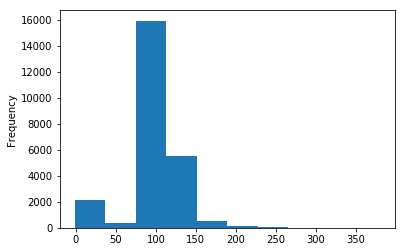

In [20]:
# create a histogram of duration, choosing an “appropriate” number of bins
movies['Duration_Minutes'].plot(kind='hist', bins=10)

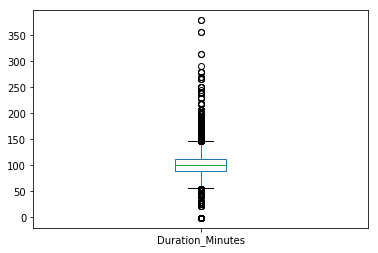

In [21]:
movies['Duration_Minutes'].plot(kind='box')

Count how many movies have average ratings :

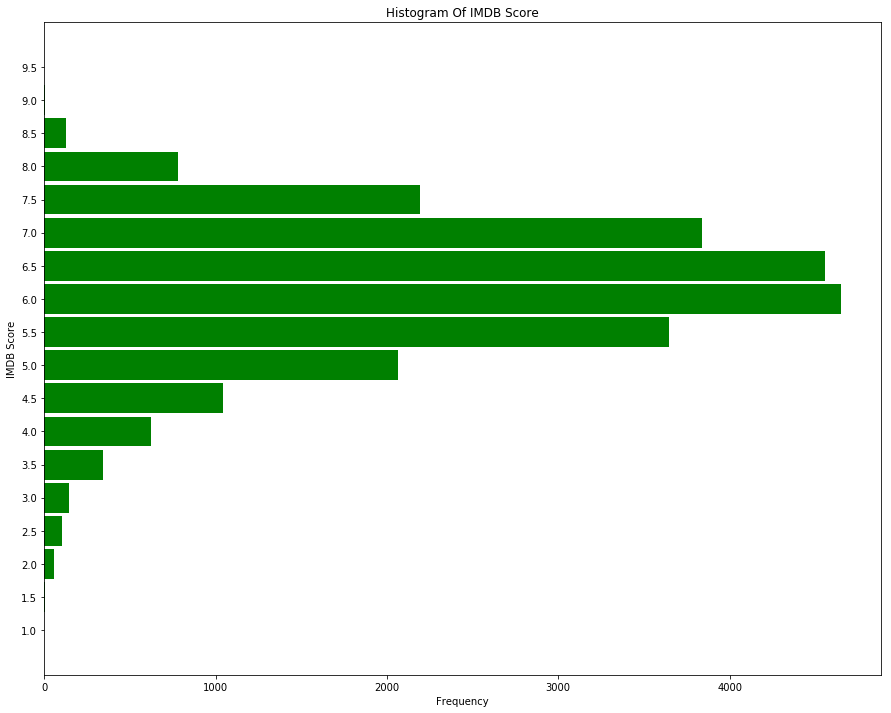

In [22]:
# movies[['Average_Rating' ,'Name']].groupby('Average_Rating').count()
imdbScore=[[]]
x=[]

for i in pl.frange(1,9.5,.5):
    imdbScore.append(len(movies.Average_Rating[(movies.Average_Rating>=i) & (movies.Average_Rating<i+.5)]))
    x.append(i)

del(imdbScore[0])

plt.figure(figsize=(15,12))
plt.title("Histogram Of IMDB Score")
plt.ylabel("IMDB Score")
plt.xlabel('Frequency')
plt.barh(x,imdbScore,height=.45 ,color='green')
plt.yticks(x)
plt.show()

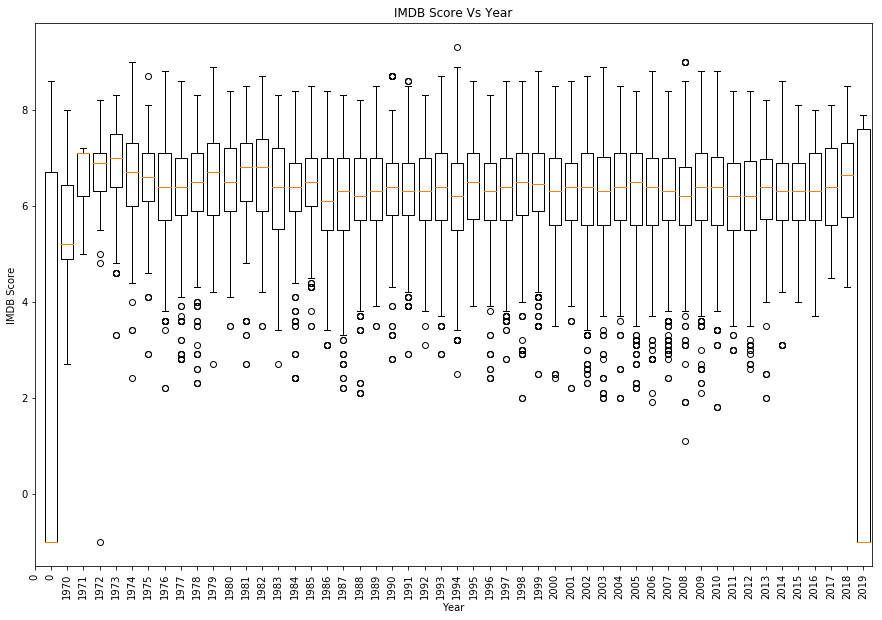

In [23]:
data=movies.dropna()
year=(movies.Year.unique()).astype(int)
year=sorted(year)

yearImdbScore=[]
numOfMovieByYear=[]

for i in year:
    tmp=movies.Average_Rating[movies.Year==i]
    yearImdbScore.append(tmp)
    numOfMovieByYear.append(len(tmp))



plt.figure(figsize=(15,10))
plt.title("IMDB Score Vs Year")
plt.ylabel("IMDB Score")
plt.xlabel('Year')
plt.boxplot(yearImdbScore,widths=.75)
year=list(np.insert(year,0,0))
plt.xticks(range(len(year)),year,rotation=90,fontsize=10)
plt.show()


Top Director VS Their Movie imdb rating

In [24]:
director=list(movies.Director.unique())
df=pd.DataFrame(columns=['director','directorScoreMean','directorImdbScore','directorMovieNUm'])

for i in director:
    tmp=list(movies.Average_Rating[movies.Director==i])
    if len(tmp)>1:
         df=df.append({'director': i,'directorScoreMean': sum(tmp)/len(tmp),'directorImdbScore': tmp,'directorMovieNUm' :len(tmp)},ignore_index=True)
    
tmp=(df.sort_values(['directorScoreMean'],ascending=False)).head(25)
directorByMeanScore=list(tmp.director)
directorByMeanScore.reverse()
ScoreByMeanScore=list(tmp.directorImdbScore)
ScoreByMeanScore.reverse()


tmp=(df.sort_values(['directorMovieNUm'],ascending=False)).head(25)
directorByMovieNum =list(tmp.director)
directorByMovieNum.reverse()
ScoreByMovieNum=list(tmp.directorImdbScore)
ScoreByMovieNum.reverse()

AttributeError: 'DataFrame' object has no attribute 'Director'

In [28]:
#directorByMovieNum
plt.figure(figsize=(11,11))
for i in range(len(directorByMovieNum)):
    for j in ScoreByMovieNum[i]:
        plt.scatter(i,j,c=j,vmin=3,vmax=10)


#tmp=plt.scatter(c=ScoreByMovieNum)
plt.colorbar(fraction=.04)
plt.title("Top Director vs Their IMDB Rating ")
plt.ylabel('Movies IMDB Rating')
plt.xlabel("\nDirector's Name")
plt.xticks(range(25),directorByMovieNum,rotation=90)

plt.show()

NameError: name 'directorByMovieNum' is not defined

<Figure size 792x792 with 0 Axes>

In [29]:
#directorByMeanScore
plt.figure(figsize=(11,11))
for i in range(len(directorByMeanScore)):
    for j in ScoreByMeanScore[i]:
        plt.scatter(i,j,c=j,vmin=6,vmax=10)

plt.xticks(range(25),directorByMeanScore,rotation=90)
plt.title("Top Director vs Their IMDB Score\n Interm Of Their Average IMDB Score ")
plt.ylabel('Movies IMDB Score')
plt.xlabel("\nDirector's Name")
plt.colorbar(fraction=.04)
plt.show()

NameError: name 'directorByMeanScore' is not defined

<Figure size 792x792 with 0 Axes>

Text(0,0.5,'Title Count')

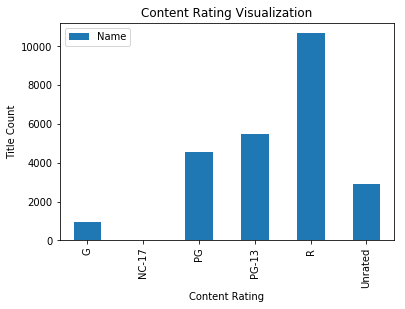

In [30]:
# use a visualization to display that same data, including a title and x and y labels
movies[['Rating' ,'Name']].groupby('Rating').count().plot(kind='bar', title='Content Rating Visualization')
plt.xlabel('Content Rating')
plt.ylabel('Title Count')

In [31]:
# calculate the average star rating for movies 2 hours or longer,
# and compare that with the average star rating for movies shorter than 2 hours
print('Avg. star rating for movies 2 hours or longer: ', movies[movies['Duration_Minutes'] >= 120]['Average_Rating'].mean(), 
 '\nAvg. star rating for movies shorter than 2 hours: ', movies[movies['Duration_Minutes'] < 120]['Average_Rating'].mean())

Avg. star rating for movies 2 hours or longer:  6.972851127074552 
Avg. star rating for movies shorter than 2 hours:  6.029662375516156


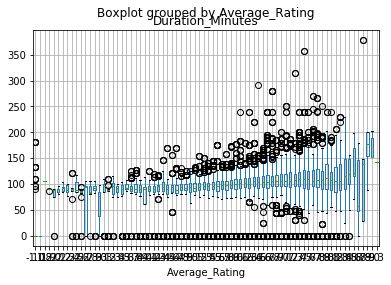

In [32]:
# use a visualization to detect whether there is a relationship between duration and star rating
movies.boxplot(column='Duration_Minutes', by='Average_Rating');

In [33]:
movies[['Profit','genre']].groupby('genre')

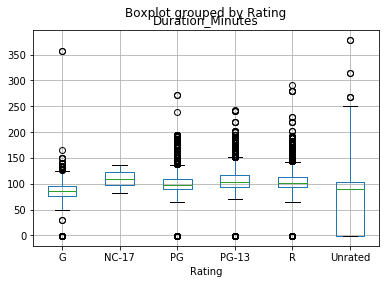

In [34]:
# visualize the relationship between content rating and duration
movies.boxplot(column='Duration_Minutes', by='Rating')

Check for Duplicacy

In [35]:
# check if there are multiple movies with the same title, and if so, determine if they are actually duplicates
result = movies[movies['Name'].isin(movies[movies.duplicated(['Name'])]['Name'])]
result.sort_values('Name')

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Average_Rating,Budget,Opening Weekend,Gross US,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
4680,$5 a Day,2008.0,"Comedy, Drama",PG-13,90.0,"Christopher Walken, Alessandro Nivola, Sharon ...",6.4,-1.0,NaN,-1.0,...,Dean Cain,English,None,None,None,Nigel Cole,None,None,None,12
4680,$5 a Day,2008.0,"Comedy, Drama",PG-13,90.0,"Christopher Walken, Alessandro Nivola, Sharon ...",6.4,-1.0,NaN,-1.0,...,Dean Cain,English,None,None,None,Nigel Cole,None,None,None,12
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",7.7,7500000.0,834501.0,32391374.0,...,Chlo\\xc3\\xab Grace Moretz,English,French,Swedish,None,Marc Webb,None,None,None,10
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",7.7,7500000.0,834501.0,32391374.0,...,Chlo\\xc3\\xab Grace Moretz,English,French,Swedish,None,Marc Webb,None,None,None,10
6636,(500) Days of Summer,2009.0,"Comedy, Drama, Romance",PG-13,95.0,"Zooey Deschanel, Joseph Gordon-Levitt, Geoffre...",7.7,7500000.0,834501.0,32391374.0,...,Chlo\\xc3\\xab Grace Moretz,English,French,Swedish,None,Marc Webb,None,None,None,10
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",6.6,-1.0,3326530.0,32945797.0,...,Elizabeth Pe\\xc3\\xb1a,English,None,None,None,Matthew Robbins,None,None,None,14
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",6.6,-1.0,3326530.0,32945797.0,...,Elizabeth Pe\\xc3\\xb1a,English,None,None,None,Matthew Robbins,None,None,None,14
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",6.6,-1.0,3326530.0,32945797.0,...,Elizabeth Pe\\xc3\\xb1a,English,None,None,None,Matthew Robbins,None,None,None,14
3056,*batteries not included,1987.0,"Comedy, Family, Fantasy, Sci-Fi",PG,106.0,"Hume Cronyn, Jessica Tandy, Frank McRae, Eliza...",6.6,-1.0,3326530.0,32945797.0,...,Elizabeth Pe\\xc3\\xb1a,English,None,None,None,Matthew Robbins,None,None,None,14
3426,...and justice for all.,1979.0,"Crime, Drama, Thriller",R,119.0,"Al Pacino, Jack Warden, John Forsythe, Lee Str...",7.4,-1.0,NaN,33300000.0,...,Lee Strasberg,English,None,None,None,Norman Jewison,None,None,None,36


In [36]:
# calculate the average star rating for each genre, but only include genres with at least 10 movies
genres = movies['Genres'].value_counts()[movies['Genres'].value_counts() > 10].index
movies[movies['Genres'].isin(genres)].groupby('Genres')['Average_Rating'].mean()

Genres
Action, Adventure                                             6.469231
Action, Adventure, Biography, Drama, History, Romance, War    6.150000
Action, Adventure, Comedy                                     5.625000
Action, Adventure, Comedy, Crime                              5.942857
Action, Adventure, Comedy, Crime, Romance, Thriller           6.100000
Action, Adventure, Comedy, Drama, Family, Fantasy, Musical    6.080000
Action, Adventure, Comedy, Family                             4.866667
Action, Adventure, Comedy, Family, Fantasy, Sci-Fi            5.133333
Action, Adventure, Comedy, Family, Romance                    5.833333
Action, Adventure, Comedy, Family, Sci-Fi                     4.962500
Action, Adventure, Comedy, Fantasy, Sci-Fi, Thriller          5.250000
Action, Adventure, Comedy, Horror, Sci-Fi, Thriller           3.942857
Action, Adventure, Comedy, Romance                            6.066667
Action, Adventure, Comedy, Sci-Fi                             6.288889

In [37]:
# Make a function which clean the data
def repp(string):
    return string.replace("'","").replace(",",",")[:-1]
#Apply that function to every entry    
movies_series = movies['Actors'].apply(repp)
#Declare a list to store the split values
actors_list = []
for movie_actors in movies_series:
    actors_list.append([e.strip() for e in movie_actors.split(',')])
#Declare a dictionary and see if the actor name key exist and then count accordingly.
actor_dict = {}
for actor in actors_list:
    for a in actor:
        if a in actor_dict:
            actor_dict[a] +=1
        else:
            actor_dict[a] = 1

actor_dict

{'John Travolta': 109,
 'Uma Thurman': 62,
 'Samuel L. Jackson': 170,
 'Bruce Willi': 11,
 'Andrew Garfield': 18,
 'Emma Stone': 37,
 'Jamie Foxx': 45,
 'Paul Giamatt': 12,
 'Tim Robbins': 73,
 'Morgan Freeman': 118,
 'Bob Gunton': 11,
 'William Sadle': 3,
 'Mark Hamill': 21,
 'Harrison Ford': 110,
 'Carrie Fisher': 24,
 'Alec Guinnes': 4,
 'Michael J. Fox': 59,
 'Christopher Lloyd': 57,
 'Lea Thompson': 27,
 'Crispin Glove': 6,
 'Emilio Estevez': 53,
 'Judd Nelson': 15,
 'Molly Ringwald': 20,
 'Ally Sheed': 2,
 'Sean Astin': 23,
 'Josh Brolin': 62,
 'Jeff Cohen': 3,
 'Corey Feldma': 6,
 'Jodie Foster': 71,
 'Anthony Hopkins': 146,
 'Lawrence A. Bonney': 3,
 'Kasi Lemmon': 6,
 'Sam Neill': 71,
 'Laura Dern': 25,
 'Jeff Goldblum': 51,
 'Richard Attenboroug': 3,
 'Matthew Broderick': 79,
 'Jeremy Irons': 60,
 'James Earl Jones': 46,
 'Whoopi Goldber': 8,
 'Brad Pitt': 104,
 'Kevin Spacey': 79,
 'Andrew Kevin Walke': 4,
 'Tom Hanks': 118,
 'Tim Allen': 52,
 'Don Rickles': 5,
 'Jim Varne':

In [38]:
#Sorted list of Actors
import operator
actor_movie_count = sorted(actor_dict.items(), key=operator.itemgetter(1))
actor_movie_count

[('Thomas Mann', 1),
 ('Oliver Cooper', 1),
 ('Jonathan Daniel Brown', 1),
 ('Dax Flam', 1),
 ('Jacob Lofland', 1),
 ('Gina Rodriguez', 1),
 ('Jenni Rivera', 1),
 ('Robert LaSard', 1),
 ('Will Brill', 1),
 ('Brahm Vaccarell', 1),
 ('Isaac Leyva', 1),
 ('Ellen Sandweiss', 1),
 ('Richard DeManincor', 1),
 ('Betsy Bake', 1),
 ('Lindsay Loha', 1),
 ('David Spad', 1),
 ('Stephen Merchant', 1),
 ('Wes Bentle', 1),
 ('David Herman', 1),
 ('Ajay Naid', 1),
 ('Jon Abrahams', 1),
 ('Carmen Electr', 1),
 ('Efren Ramirez', 1),
 ('Aaron Ruel', 1),
 ('Bill Hade', 1),
 ('Martin Stringe', 1),
 ('Bee Vang', 1),
 ('Christopher Carley', 1),
 ('Ahney He', 1),
 ('Adelaide Clemens', 1),
 ('Kit Harington', 1),
 ('Steve Carel', 1),
 ('Lucy Walter', 1),
 ('Kevin McKid', 1),
 ('Wiley Wiggins', 1),
 ('Justin Chon', 1),
 ('Jonathan Keltz', 1),
 ('Sarah Wrigh', 1),
 ('Aasif Mandv', 1),
 ('David A.R. White', 1),
 ('Andrea Logan White', 1),
 ('Gerald R. Mole', 1),
 ('Antony Acker', 1),
 ('Mark Barret', 1),
 ('Eminem

In [39]:
import random
from wordcloud import WordCloud, STOPWORDS
text = (str(movies['genre']))
plt.subplots(figsize=(20,15))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=1500,
                          height=1200
                         ).generate(text)


plt.imshow(wordcloud)
plt.title('genre')
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [40]:
movies["genre"].value_counts()

Drama          4876
Comedy         3475
Thriller       2500
Romance        1994
Action         1885
Crime          1713
Adventure      1438
Horror         1122
Sci-Fi          988
Fantasy         956
Mystery         890
Family          825
Biography       799
War             369
Animation       336
Documentary     282
Western         174
Name: genre, dtype: int64

In [41]:
# movies.Director.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
# # plt.title('TOP 10 Directors OF MOVIES')

In [42]:
# movies.Actors.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
# plt.title('TOP 10 Actors OF MOVIES')

In [43]:
# movies["Year"].value_counts().to_frame()

In [44]:
g=movies.groupby('Year')
g.count().head(10)

,Name,Genres,Rating,Duration_Minutes,Actors,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
Year,,,,,,,,,,,,,,,,,,,,,
0.0,607,607,607,607,607,607,607,0,607,607,...,213,322,28,17,9,607,30,6,2,607
1970.0,26,26,26,26,26,26,26,0,26,26,...,25,26,7,1,1,26,4,3,1,26
1971.0,8,8,8,8,8,8,8,0,8,8,...,8,8,5,1,0,8,5,0,0,8
1972.0,121,121,121,121,121,121,121,6,121,121,...,121,121,52,8,3,121,0,0,0,121
1973.0,365,365,365,365,365,365,365,16,365,365,...,363,365,104,18,1,365,12,2,2,365
1974.0,305,305,305,305,305,305,305,5,305,305,...,301,305,66,32,15,305,11,0,0,305
1975.0,305,305,305,305,305,305,305,12,305,305,...,299,305,73,23,6,305,11,5,3,305
1976.0,313,313,313,313,313,313,313,12,313,313,...,313,312,70,24,8,313,8,5,5,313
1977.0,308,308,308,308,308,308,308,22,308,308,...,308,308,73,29,11,308,20,8,1,308


In [45]:
#top 10 rating movies 
Sortedrating= movies.sort_values(['Average_Rating'], ascending=False)
Sortedrating.head(10)

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Average_Rating,Budget,Opening Weekend,Gross US,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
2,The Shawshank Redemption,1994.0,Drama,R,142.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",9.3,25000000.0,727326.0,28341469.0,...,William Sadler,English,None,None,None,Frank Darabont,None,None,None,12
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,185000000.0,158411483.0,534858444.0,...,Michael Caine,English,Mandarin,None,None,Christopher Nolan,None,None,None,28
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,185000000.0,158411483.0,534858444.0,...,Michael Caine,English,Mandarin,None,None,Christopher Nolan,None,None,None,28
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,185000000.0,158411483.0,534858444.0,...,Michael Caine,English,Mandarin,None,None,Christopher Nolan,None,None,None,28
34,The Dark Knight,2008.0,"Action, Crime, Drama, Thriller",PG-13,152.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,185000000.0,158411483.0,534858444.0,...,Michael Caine,English,Mandarin,None,None,Christopher Nolan,None,None,None,28
194,The Godfather: Part II,1974.0,"Crime, Drama",R,202.0,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",9.0,13000000.0,NaN,57300000.0,...,Diane Keaton,English,Italian,Spanish,Latin,Francis Ford Coppola,None,None,None,37
194,The Godfather: Part II,1974.0,"Crime, Drama",R,202.0,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",9.0,13000000.0,NaN,57300000.0,...,Diane Keaton,English,Italian,Spanish,Latin,Francis Ford Coppola,None,None,None,37
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",8.9,8000000.0,9311882.0,107928762.0,...,Bruce Willis,English,Spanish,French,None,Quentin Tarantino,None,None,None,26
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",8.9,8000000.0,9311882.0,107928762.0,...,Bruce Willis,English,Spanish,French,None,Quentin Tarantino,None,None,None,26
9253,Strangers: The Story of a Mother and Daughter,1979.0,"Drama, actor",Unrated,88.0,"Bette Davis, Gena Rowlands, Ford Rainey, Donal...",8.9,-1.0,NaN,-1.0,...,Donald Moffat,English,None,None,None,Milton Katselas,None,None,None,3


In [46]:
# low rated movies
lowratedmovies= movies.query('(Average_Rating > 0) & (Average_Rating < 3.0)')
lowratedmovies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Average_Rating,Budget,Opening Weekend,Gross US,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
156,The Cloth,2013.0,"Action, Fantasy, Horror",Unrated,88.0,"Danny Trejo, Perla Rodr\\xc3\\xadguez, Eric Ro...",2.5,4000000.0,NaN,-1.0,...,Rachele Brooke Smith,English,None,None,None,Justin Price,None,None,None,3
156,The Cloth,2013.0,"Action, Fantasy, Horror",Unrated,88.0,"Danny Trejo, Perla Rodr\\xc3\\xadguez, Eric Ro...",2.5,4000000.0,NaN,-1.0,...,Rachele Brooke Smith,English,None,None,None,Justin Price,None,None,None,3
156,The Cloth,2013.0,"Action, Fantasy, Horror",Unrated,88.0,"Danny Trejo, Perla Rodr\\xc3\\xadguez, Eric Ro...",2.5,4000000.0,NaN,-1.0,...,Rachele Brooke Smith,English,None,None,None,Justin Price,None,None,None,3
187,Devils of War,2013.0,"Action, Horror",Unrated,74.0,"Lawrence Anthony, Jerry L. Buxbaum, Jamin Wats...",2.0,-1.0,NaN,-1.0,...,Jeremiah Grace,English,None,None,None,Eli Dorsey,Eli Dorsey,Bezenby,Kind of okay,2
187,Devils of War,2013.0,"Action, Horror",Unrated,74.0,"Lawrence Anthony, Jerry L. Buxbaum, Jamin Wats...",2.0,-1.0,NaN,-1.0,...,Jeremiah Grace,English,None,None,None,Eli Dorsey,Eli Dorsey,Bezenby,Kind of okay,2


In [47]:
Sortedrevenue= movies.sort_values(['Budget'], ascending=False)

In [48]:
#top 5 high revenue movies
Sortedrevenue.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Average_Rating,Budget,Opening Weekend,Gross US,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
9522,Avengers: Infinity War,2018.0,"Action, Adventure, Sci-Fi",PG-13,149.0,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...",8.5,321000000.0,257698183.0,678815482.0,...,Chris Evans,English,None,None,None,Anthony Russo,Joe Russo,None,None,11
9522,Avengers: Infinity War,2018.0,"Action, Adventure, Sci-Fi",PG-13,149.0,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...",8.5,321000000.0,257698183.0,678815482.0,...,Chris Evans,English,None,None,None,Anthony Russo,Joe Russo,None,None,11
9522,Avengers: Infinity War,2018.0,"Action, Adventure, Sci-Fi",PG-13,149.0,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...",8.5,321000000.0,257698183.0,678815482.0,...,Chris Evans,English,None,None,None,Anthony Russo,Joe Russo,None,None,11
9408,Justice League,2017.0,"Action, Adventure, Fantasy, Sci-Fi",PG-13,120.0,"Ben Affleck, Gal Gadot, Jason Momoa, Ezra Miller",6.5,300000000.0,93842239.0,229024295.0,...,Ezra Miller,English,Irish,Russian,Icelandic,Zack Snyder,None,None,None,25
9408,Justice League,2017.0,"Action, Adventure, Fantasy, Sci-Fi",PG-13,120.0,"Ben Affleck, Gal Gadot, Jason Momoa, Ezra Miller",6.5,300000000.0,93842239.0,229024295.0,...,Ezra Miller,English,Irish,Russian,Icelandic,Zack Snyder,None,None,None,25


In [49]:
m= Sortedrevenue.query('(Budget > 500)')
print('number of movies with more than half million revenue:')
len(m)

number of movies with more than half million revenue:


16009

In [50]:
n= Sortedrevenue.query('(Budget < 500)')
print('number of movies with less than half million revenue:')
len(n)

number of movies with less than half million revenue:


8613

In [51]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24622 entries, 0 to 9836
Data columns (total 29 columns):
Name                     24622 non-null object
Year                     24622 non-null float64
Genres                   24622 non-null object
Rating                   24622 non-null object
Duration_Minutes         24622 non-null float64
Actors                   24622 non-null object
Average_Rating           24622 non-null float64
Budget                   24622 non-null float64
Opening Weekend          14844 non-null float64
Gross US                 24622 non-null float64
Gross WW                 24622 non-null float64
Language                 24331 non-null object
Production Company       24622 non-null object
Profit                   24622 non-null float64
Status                   24622 non-null bool
genre                    24622 non-null object
Cast1                    24622 non-null object
Cast2                    24185 non-null object
Cast3                    24130 non-null 

In [52]:
# from wordcloud import WordCloud, STOPWORDS
# plt.subplots(figsize=(10,10))
# text = (str(m['Actors']))
# wordcloud = WordCloud(
#                           stopwords=STOPWORDS,
#                           background_color='white',
#                           width=1200,
#                           height=1000
#                          ).generate(text)


# plt.imshow(wordcloud)
# plt.title('ACTORS IN HIGH REVENUE MOVIES')
# plt.axis('off')
# plt.show()

In [53]:
# from wordcloud import WordCloud, STOPWORDS
# plt.subplots(figsize=(10,10))
# text = (str(n['Actors']))
# wordcloud = WordCloud(
#                           stopwords=STOPWORDS,
#                           background_color='white',
#                           width=1200,
#                           height=1000
#                          ).generate(text)


# plt.imshow(wordcloud)
# plt.title('ACTORS IN LOW REVENUE MOVIES')
# plt.axis('off')
# plt.show()

In [54]:
numeric_features=movies._get_numeric_data().columns.values.tolist()
numeric_features

['Year',
 'Duration_Minutes',
 'Average_Rating',
 'Budget',
 'Opening Weekend',
 'Gross US',
 'Gross WW',
 'Profit',
 'Status',
 'CountOfMoviesDirected']

# Correlation heatmap

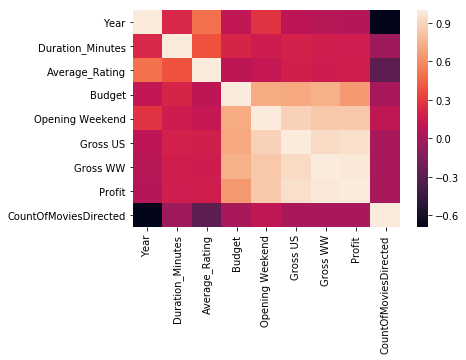

In [55]:
col = list(movies.describe().columns)
features=col
features
sns.heatmap(movies[features].corr())
plt.show()

In [56]:
correlation=movies.corr()
correlation

,Year,Duration_Minutes,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Profit,Status,CountOfMoviesDirected
Year,1.000000,0.220767,0.494260,0.107838,0.278364,0.089157,0.067954,0.063443,0.181120,-0.694157
Duration_Minutes,0.220767,1.000000,0.386839,0.207225,0.163834,0.198617,0.175447,0.168387,0.157816,-0.029580
Average_Rating,0.494260,0.386839,1.000000,0.094556,0.120391,0.181257,0.163036,0.176036,0.182558,-0.285424
Budget,0.107838,0.207225,0.094556,1.000000,0.719234,0.713744,0.742947,0.645244,0.264580,0.009807
Opening Weekend,0.278364,0.163834,0.120391,0.719234,1.000000,0.885164,0.846269,0.844191,0.260679,0.105554
Gross US,0.089157,0.198617,0.181257,0.713744,0.885164,1.000000,0.925435,0.952404,0.400416,0.012889
Gross WW,0.067954,0.175447,0.163036,0.742947,0.846269,0.925435,1.000000,0.983934,0.321043,0.010136
Profit,0.063443,0.168387,0.176036,0.645244,0.844191,0.952404,0.983934,1.000000,0.344471,0.010651
Status,0.181120,0.157816,0.182558,0.264580,0.260679,0.400416,0.321043,0.344471,1.000000,-0.075036
CountOfMoviesDirected,-0.694157,-0.029580,-0.285424,0.009807,0.105554,0.012889,0.010136,0.010651,-0.075036,1.000000


In [57]:
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Average_Rating,Budget,Opening Weekend,Gross US,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",8.9,8000000.0,9311882.0,107928762.0,...,Bruce Willis,English,Spanish,French,None,Quentin Tarantino,None,None,None,26
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",8.9,8000000.0,9311882.0,107928762.0,...,Bruce Willis,English,Spanish,French,None,Quentin Tarantino,None,None,None,26
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",6.6,200000000.0,91608337.0,202853933.0,...,Paul Giamatti,English,None,None,None,Marc Webb,None,None,None,10
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",6.6,200000000.0,91608337.0,202853933.0,...,Paul Giamatti,English,None,None,None,Marc Webb,None,None,None,10
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",6.6,200000000.0,91608337.0,202853933.0,...,Paul Giamatti,English,None,None,None,Marc Webb,None,None,None,10


# Checking that we can replace Rating with Monitary Value

We are going to check to see if each rating has a different enough distribution to justify replacing each Rating with their respective mean. This is going to be done by a two sample t test cross comparing each Rating with eachother, making 7 t tests in total. The actaul replacement will be done in the prediction alogrthm. 

In [58]:
#Need to change all movie ratings that are NC-17 to Unrated
movies["Rating"] = movies["Rating"].replace('NC-17', 'Unrated')
#Removing all movies that dont have a Gross US
movies = movies[movies['Gross US'] > 0]
movies = movies[movies['Budget'] > 0]

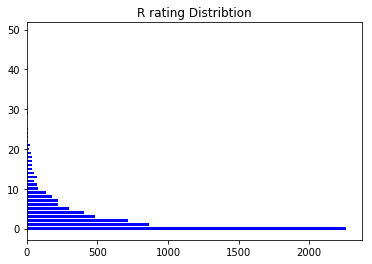

Mean Value:  27731046.84657577


In [59]:
#Graphing R rating vs Gross Earning distrubition
R = movies[movies["Rating"] == 'R']
R = R[R["Gross US"] > 0]
R = R.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingR = R.groupby(pd.cut(R["Gross US"], groups)).count()
y_pos = np.arange(len(groupingR))
plt.barh(y_pos , groupingR["Gross US"], 1/1.5, color="blue")
plt.title("R rating Distribtion")
plt.show()
print("Mean Value: ", R["Gross US"].mean())

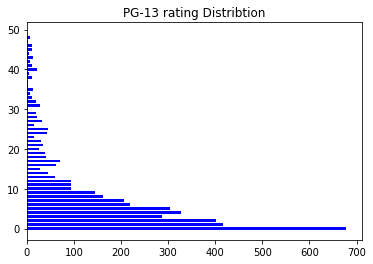

Mean Value:  66627653.53356562


In [60]:
#Graphing PG13 rating vs Gross Earning distrubition
PG13 = movies[movies["Rating"] == 'PG-13']
PG13 = PG13[PG13["Gross US"] > 0]
PG13 = PG13.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingPG13 = PG13.groupby(pd.cut(PG13["Gross US"], groups)).count()
y_pos = np.arange(len(groupingPG13))
plt.barh(y_pos , groupingPG13["Gross US"], 1/1.5, color="blue")
plt.title("PG-13 rating Distribtion")
plt.show()
print("Mean Value: ", PG13["Gross US"].mean())

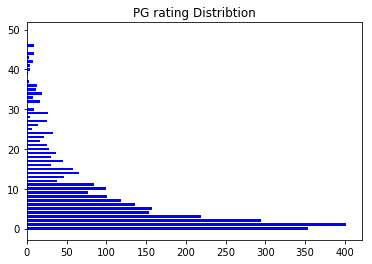

Mean Value:  64459804.39011748


In [61]:
#Graphing PG rating vs Gross Earning distrubition
PG = movies[movies["Rating"] == 'PG']
PG = PG[PG["Gross US"] > 0]
PG = PG.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingPG = PG.groupby(pd.cut(PG["Gross US"], groups)).count()
y_pos = np.arange(len(groupingPG))
plt.barh(y_pos , groupingPG["Gross US"], 1/1.5, color="blue")
plt.title("PG rating Distribtion")
plt.show()
print("Mean Value: ", PG["Gross US"].mean())

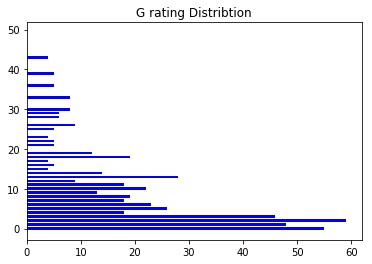

Mean Value:  76789860.8812616


In [62]:
#Graphing G rating vs Gross Earning distrubition
G = movies[movies["Rating"] == 'G']
G = G[G["Gross US"] > 0]
G = G.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingG = G.groupby(pd.cut(G["Gross US"], groups)).count()
y_pos = np.arange(len(groupingG))
plt.barh(y_pos , groupingG["Gross US"], 1/1.5, color="blue")
plt.title("G rating Distribtion")
plt.show()
print("Mean Value: ", G["Gross US"].mean())

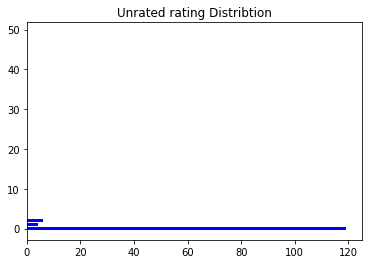

Mean Value:  1845049.3643410853


In [63]:
#Graphing Unrated rating vs Gross Earning distrubition
UN = movies[movies["Rating"] == 'Unrated']
UN = UN[UN["Gross US"] > 0]
UN = UN.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingUN = UN.groupby(pd.cut(UN["Gross US"], groups)).count()
y_pos = np.arange(len(groupingUN))
plt.barh(y_pos , groupingUN["Gross US"], 1/1.5, color="blue")
plt.title("Unrated rating Distribtion")
plt.show()
print("Mean Value: ", UN["Gross US"].mean())

In [64]:
#Checking to see if teh ratings are statiscally different are statistically different
print("R-PG13: ", stats.ttest_ind(R["Gross US"], PG13["Gross US"], equal_var = False))
print("R-PG: ", stats.ttest_ind(R["Gross US"], PG["Gross US"], equal_var = False))
print("R-G: ", stats.ttest_ind(R["Gross US"], G["Gross US"], equal_var = False))
print("PG13-PG: ", stats.ttest_ind(PG13["Gross US"], PG["Gross US"], equal_var = False))
print("PG13-G: ", stats.ttest_ind(PG13["Gross US"], G["Gross US"], equal_var = False))
print("PG-G: ", stats.ttest_ind(PG["Gross US"], G["Gross US"], equal_var = False))
print("UN-R: ", stats.ttest_ind(UN["Gross US"], R["Gross US"], equal_var = False))
print("UN-PG13: ", stats.ttest_ind(UN["Gross US"], PG13["Gross US"], equal_var = False))
print("UN-PG: ", stats.ttest_ind(UN["Gross US"], PG["Gross US"], equal_var = False))
print("UN-G: ", stats.ttest_ind(UN["Gross US"], G["Gross US"], equal_var = False))

R-PG13:  Ttest_indResult(statistic=-26.93717021962157, pvalue=7.651725199969978e-150)
R-PG:  Ttest_indResult(statistic=-25.16653548956893, pvalue=1.0686218608345783e-128)
R-G:  Ttest_indResult(statistic=-13.82939828154472, pvalue=1.342323703309665e-37)
PG13-PG:  Ttest_indResult(statistic=1.1122334153957845, pvalue=0.2660766236412208)
PG13-G:  Ttest_indResult(statistic=-2.691723095485679, pvalue=0.007275454241692271)
PG-G:  Ttest_indResult(statistic=-3.2608057442589606, pvalue=0.0011636533936909416)
UN-R:  Ttest_indResult(statistic=-44.4108774518369, pvalue=2.3911836105266268e-219)
UN-PG13:  Ttest_indResult(statistic=-45.70793855861668, pvalue=0.0)
UN-PG:  Ttest_indResult(statistic=-43.6931377515883, pvalue=7e-323)
UN-G:  Ttest_indResult(statistic=-21.190833942210748, pvalue=2.763235168464325e-73)


Statiscally non of these values with high accuracy are equal to eachother. This allows us to say that each rating has statiscally different value. Lets now replace the Rating with the value of the mean of the rating to signify the value that the rating has upon the movie.

In [65]:
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Average_Rating,Budget,Opening Weekend,Gross US,...,Cast4,Lang1,Lang2,Lang3,Lang4,Director_One,Director_two,Director_three,Director_four,CountOfMoviesDirected
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",8.9,8000000.0,9311882.0,107928762.0,...,Bruce Willis,English,Spanish,French,None,Quentin Tarantino,None,None,None,26
0,Pulp Fiction,1994.0,"Crime, Drama",R,154.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...",8.9,8000000.0,9311882.0,107928762.0,...,Bruce Willis,English,Spanish,French,None,Quentin Tarantino,None,None,None,26
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",6.6,200000000.0,91608337.0,202853933.0,...,Paul Giamatti,English,None,None,None,Marc Webb,None,None,None,10
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",6.6,200000000.0,91608337.0,202853933.0,...,Paul Giamatti,English,None,None,None,Marc Webb,None,None,None,10
1,The Amazing Spider-Man 2,2014.0,"Action, Adventure, Sci-Fi",PG-13,142.0,"Andrew Garfield, Emma Stone, Jamie Foxx, Paul ...",6.6,200000000.0,91608337.0,202853933.0,...,Paul Giamatti,English,None,None,None,Marc Webb,None,None,None,10


# PREDICTION

In [66]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn import linear_model

import warnings
warnings.filterwarnings("ignore")

In [67]:
movies.fillna(value=0,axis=1,inplace=True)
print(movies.set_index(['Budget','Opening Weekend','Gross US'])
         .stack()
         .reset_index(name='value')
         )

            Budget  Opening Weekend     Gross US                level_3  \
0        8000000.0        9311882.0  107928762.0                   Name   
1        8000000.0        9311882.0  107928762.0                   Year   
2        8000000.0        9311882.0  107928762.0                 Genres   
3        8000000.0        9311882.0  107928762.0                 Rating   
4        8000000.0        9311882.0  107928762.0       Duration_Minutes   
5        8000000.0        9311882.0  107928762.0                 Actors   
6        8000000.0        9311882.0  107928762.0         Average_Rating   
7        8000000.0        9311882.0  107928762.0               Gross WW   
8        8000000.0        9311882.0  107928762.0               Language   
9        8000000.0        9311882.0  107928762.0     Production Company   
10       8000000.0        9311882.0  107928762.0                 Profit   
11       8000000.0        9311882.0  107928762.0                 Status   
12       8000000.0       

In [68]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14248 entries, 0 to 9835
Data columns (total 29 columns):
Name                     14248 non-null object
Year                     14248 non-null float64
Genres                   14248 non-null object
Rating                   14248 non-null object
Duration_Minutes         14248 non-null float64
Actors                   14248 non-null object
Average_Rating           14248 non-null float64
Budget                   14248 non-null float64
Opening Weekend          14248 non-null float64
Gross US                 14248 non-null float64
Gross WW                 14248 non-null float64
Language                 14248 non-null object
Production Company       14248 non-null object
Profit                   14248 non-null float64
Status                   14248 non-null bool
genre                    14248 non-null object
Cast1                    14248 non-null object
Cast2                    14248 non-null object
Cast3                    14248 non-null 

In [69]:
features = ['Rating', 'Genres', 'Cast1', 'Cast2' ,'Cast3', 'Cast4','Director_One','Director_two','Director_three']
target = ['Profit']
PROFIT_MARIGINE = 1

In [70]:
train, test = train_test_split(movies,test_size=0.30)


In [71]:
#Fill the training and test data with require information
train_x = train[features] 
train_y = train[target]
train_gross = train['Profit']
test_x = test[features]
test_y = test[target]

Here we are going to change the Rating value to the mean value of the Gross US made by all movies in that rating. Please not that we do NOT take the movies in the test array into the mean value of the Gross US. Furthermore we only replace the movies with the mean value of the train movies. This means that any test movie rating are replace with the training moviie's mean gross US for that rating.

In [72]:
R = train_gross[train_x["Rating"] == 'R']
PG13 = train_gross[train_x["Rating"] == 'PG-13']
PG = train_gross[train_x["Rating"] == 'PG']
G = train_gross[train_x["Rating"] == 'G']
UN = train_gross[train_x["Rating"] == 'Unrated']
#a baseline for the value of movies made in that rating
train_x["Rating"] = train_x["Rating"].replace('R', R.mean())
train_x["Rating"] = train_x["Rating"].replace('PG-13', PG13.mean())
train_x["Rating"] = train_x["Rating"].replace('PG', PG.mean())
train_x["Rating"] = train_x["Rating"].replace('G', G.mean())
train_x["Rating"] = train_x["Rating"].replace('Unrated', UN.mean())
train_x["Rating"] = train_x["Rating"].astype(float)
#a baseline for the value of movies made in that rating
test_x["Rating"] = test_x["Rating"].replace('R', R.mean())
test_x["Rating"] = test_x["Rating"].replace('PG-13', PG13.mean())
test_x["Rating"] = test_x["Rating"].replace('PG', PG.mean())
test_x["Rating"] = test_x["Rating"].replace('G', G.mean())
test_x["Rating"] = test_x["Rating"].replace('Unrated', UN.mean())
test_x["Rating"] = test_x["Rating"].astype(float)

In [73]:
# calculate the average Gross US for each genre, but only include genres with at least 10 movies
cast = ["Director_One", "Director_two", "Director_three"]
for c in cast:
    dirList = train_x[c].unique()
    unknownCast = test_x[~(test_x[c].isin(dirList))][c].unique()

    dirvalues = pd.DataFrame()
    dirvalues["List"] = dirList
    dirvalues["Value"] = dirList
    for g in dirList:
        dirvalues.loc[dirvalues['List'] == g, "Value"] = train_gross[train_x[c] == g].mean()
    for g in dirList:
        train_x[c] = train_x[c].replace(g, dirvalues[dirvalues["List"] == g]["Value"].mean())
        test_x[c] = test_x[c].replace(g, dirvalues[dirvalues["List"] == g]["Value"].mean())
    avg = train_gross.mean()
    for g in unknownCast:
        test_x[c] = test_x[c].replace(g, avg)

In [ ]:
cast = ["Cast1", "Cast2", "Cast3", "Cast4"]
for c in cast:
    castList = train_x[c].unique()
    unknownCast = test_x[~(test_x[c].isin(castList))][c].unique()

    castValues = pd.DataFrame()
    castValues["List"] = castList
    castValues["Value"] = castList
    for g in castList:
        castValues.loc[castValues['List'] == g, "Value"] = train_gross[train_x[c] == g].mean()
    for g in castList:
        train_x[c] = train_x[c].replace(g, castValues[castValues["List"] == g]["Value"].mean())
        test_x[c] = test_x[c].replace(g, castValues[castValues["List"] == g]["Value"].mean())
    avg = train_gross.mean()
    for g in unknownCast:
        test_x[c] = test_x[c].replace(g, avg)

In [ ]:
# calculate the average Gross US for each genre, but only include genres with at least 10 movies
genreList = train_x['Genres'].unique()
unknownGenres = test_x[~(test_x['Genres'].isin(genreList))]['Genres'].unique()

genreValues = pd.DataFrame()
genreValues["List"] = genreList
genreValues["Value"] = genreList
for g in genreList:
    genreValues.loc[genreValues['List'] == g, "Value"] = train_gross[train_x['Genres'] == g].mean()
for g in genreList:
    train_x["Genres"] = train_x["Genres"].replace(g, genreValues[genreValues["List"] == g]["Value"].mean())
    test_x["Genres"] = test_x["Genres"].replace(g, genreValues[genreValues["List"] == g]["Value"].mean())
avg = train_gross.mean()
for g in unknownGenres:
    test_x["Genres"] = test_x["Genres"].replace(g, avg)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_x_std = pd.DataFrame(sc.fit_transform(train_x),columns=features)
test_x_std = pd.DataFrame(sc.transform(test_x), columns=features)


In [ ]:
train_x_std.head(2)

In [ ]:
corr = train_x_std.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
            cmap= 'YlGnBu')
plt.show()

In [ ]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(train_x_std,train_y)
predicted_rating = model.predict(test_x_std)

In [ ]:
for i in range(0, len(predicted_rating)):
    if(predicted_rating[i][0] > PROFIT_MARIGINE):
        predicted_rating[i][0] = 1
    else:
        predicted_rating[i][0] = 0
test_y = np.where(test_y['Profit']> PROFIT_MARIGINE, True, False)


In [ ]:
#Calculate cross valiation scores
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, train_x_std, train_y, cv=5)
print("Linear regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
#Calculate score of the model
from sklearn import metrics 
r2score  = metrics.r2_score(test_y,predicted_rating)
print('R2 score is: {}'.format(round(r2score,2)))
accuracy = 0
for i in range(0, len(predicted_rating)):
    if(predicted_rating[i][0]  == test_y[i]):
        accuracy = accuracy + 1
print(accuracy/len(predicted_rating))


In [ ]:
clf = svm.SVC(gamma=0.001, C=100)
train_y = np.where(train_y['Profit']> PROFIT_MARIGINE, True, False)
clf.fit( train_x, train_y)
predictions = clf.predict(test_x)
confuse = metrics.confusion_matrix(test_y, predictions)
print(confuse)
accuracy = (confuse[0][0] + confuse[1][1])/(confuse[0][0] + confuse[1][0] + confuse[0][1] + confuse[1][1])
print("Accuracy of SVC: ", accuracy)

In [ ]:

high_score_data= movies.loc[movies['Gross US']>=3] #only count of movies with score>= 3.0
sns.countplot(high_score_data['Gross US'],label='Gross US')
plt.show()

In [ ]:
#Calculate cross valiation scores
from sklearn.model_selection import cross_val_score
print(test_y.shape)
scores = cross_val_score(rf, test_x_std,np.ravel(test_y), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('Maximum score in cross valuation is: %0.2f'%(scores.max()))

In [ ]:
ser = pd.Series(rf.feature_importances_,index=features) #feature importance
ser.sort_values(ascending=False,inplace=True)
ser.plot(kind='bar')